# 0. Imports

In [111]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import sklearn

In [112]:
df = pd.read_csv("./playground-series-s4e9/train.csv",index_col='id')
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


# 1. Column Transformations

In [116]:
def EngineTransformer(X):
	X = X.copy()

	# In case the engine column did not contain the string
	# X['horse_power'] = -1
	# X['tank_size'] = -1
	# X['num_cylinders'] = -1

	X['horse_power'] = X['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
	X['tank_size'] = X['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
	X['num_cylinders'] = X['engine'].str.extract(r'(\d+)\sCylinder').astype(float) 
	   
	# Drop the original 'engine' column
	X.drop('engine', axis=1, inplace=True)
	return X

In [117]:
def TransmissionTransformer(X):
	# Initialize all attributes to False
    X = X.copy()

    X['automatic'] = False
    X['manual'] = False
    X['dual'] = False
    
    # Categorize as 'dual' if it contains 'Dual'
    X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
    
    # Ensure 'dual' is boolean before using ~ operator
    X['dual'] = X['dual'].astype(bool)
    # Categorize as 'automatic' if it contains AT, A/T, CVT, or Automatic (but not Dual)
    X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
    # Categorize as 'manual' if it contains MT, M/T, or Manual (but not Dual)
    X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True

    # Drop the original 'transmission' column
    X.drop('transmission', axis=1, inplace=True)
    
    return X

In [118]:
def ColorTransformer(X):
	X = X.copy()
	# Colors to keep (top 12)
	ext_colors = list(df["ext_col"].value_counts()[:12].index)
	int_colors = list(df["int_col"].value_counts()[:12].index)
	int_colors.remove("–")
	# Categorize as 'other' if not in the top 12 colors
	X.loc[~X['ext_col'].isin(ext_colors), 'ext_col'] = 'other'
	X.loc[~X['int_col'].isin(int_colors), 'int_col'] = 'other'
	
	return X

In [119]:
def BrandTransformer(X):
	X = X.copy()
	# Brands to keep (top 24)
	brands = list(df["brand"].value_counts()[:24].index)
	# Categorize as 'other' if not in the top 24 brands
	X.loc[~X['brand'].isin(brands), 'brand'] = 'other'
	
	return X

In [120]:
def CleanTitleTransformer(X):
    X = X.copy()
    # Change the "Yes" to the boolean True
    X['clean_title'] = X['clean_title'].replace('Yes', True)
    
    return X

In [121]:
def AccidentTransformer(X):
	X = X.copy()
	# Change the "None reported" to the boolean True and At least 1 accident or damage reported to False
	X['accident'] = X['accident'].replace('None reported', False)
	X['accident'] = X['accident'].replace('At least 1 accident or damage reported', True)
	
	return X

In [122]:
def ColumnOrganizer(X):
	X = X.copy()
	X = X.drop(columns=['model'])

	# Move the target column to the end, in case X is the test set there is no target column
	cols = X.columns.tolist()
	if "price" in cols:
		cols.append(cols.pop(cols.index('price')))
		X = X[cols]

	return X

In [123]:
def columnTransformer(X):
    X = EngineTransformer(X)
    X = TransmissionTransformer(X)
    X = ColorTransformer(X)
    X = BrandTransformer(X)
    X = CleanTitleTransformer(X)
    X = AccidentTransformer(X)
    X = ColumnOrganizer(X)
    
    return X

# 2. Filling Null Values

### Strategies

Since the number of NUlls is very low (3%, 1.5% of the data respectively) we have 2 options:

- Strategy 1 - dropping those entries and train the model without them.

- Strategy 2 - Replacing them with another value:
1. **fuel_type** - Gasoline, because it is by far the most common option in the train dataset.
2. **accident** - False, Assuming if no accident was mentioned, then there was no accident.
3. **clean_title** - Likewise.
4. **horse_power** - The average horse power in the train dataset, rounded to the nearest integer.
5. **tank_size** - Likewise.
6. **num_cylinders** - Likewise.

We chose strategy 2 to preserve this data.

In [124]:
def Imputer(X):
	X = X.copy()
	
	X["fuel_type"] = X["fuel_type"].replace('not supported', "Gasoline")
	X["fuel_type"] = X["fuel_type"].replace('–', "Gasoline")
	X["fuel_type"] = X["fuel_type"].replace(pd.NA, "Gasoline")

	X['accident'] = X['accident'].fillna(False)

	X['clean_title'] = X['clean_title'].fillna(False)

	# need to be changed into the mean of the training set, because when we are predicting the test set, we don't want to use the test set mean
	X['horse_power'] = X['horse_power'].fillna(round(X['horse_power'].mean()))

	X['tank_size'] = X['tank_size'].fillna(round(X['tank_size'].mean()))

	X['num_cylinders'] = X['num_cylinders'].fillna(round(X['num_cylinders'].mean()))
	
	return X

In [125]:
def preprocessor(X):
	X = columnTransformer(X)
	X = Imputer(X)
	
	return(X)

# I. Applying the Preprocessing steps

In [126]:
df_preprocessed = preprocessor(df)

/tmp/ipykernel_15848/771887330.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[X['transmission'].str.contains(r'\b(Dual|At/Mt)\b', case=False, na=False), 'dual'] = True
/tmp/ipykernel_15848/771887330.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(AT|A/T|CVT|Automatic)\b', case=False, na=False)) & ~X['dual'], 'automatic'] = True
/tmp/ipykernel_15848/771887330.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  X.loc[(X['transmission'].str.contains(r'\b(MT|M/T|Manual)\b', case=False, na=False)) & ~X['dual'], 'manual'] = True
/tmp/ipykernel_15848/231967549.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in

In [127]:
df_preprocessed.head()

,brand,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,price
id,,,,,,,,,,,,,,,
0,other,2007,213000,Gasoline,Yellow,Gray,False,True,172.0,1.6,4.0,True,False,False,4200
1,Lincoln,2002,143250,Gasoline,Silver,Beige,True,True,252.0,3.9,8.0,True,False,False,4999
2,Chevrolet,2002,136731,E85 Flex Fuel,Blue,Gray,False,True,320.0,5.3,8.0,True,False,False,13900
3,other,2017,19500,Gasoline,Black,Black,False,True,420.0,5.0,8.0,False,False,True,45000
4,Mercedes-Benz,2021,7388,Gasoline,Black,Beige,False,True,208.0,2.0,4.0,True,False,False,97500


In [128]:
df_preprocessed.dtypes

brand             object
model_year         int64
milage             int64
fuel_type         object
ext_col           object
int_col           object
accident            bool
clean_title         bool
horse_power      float64
tank_size        float64
num_cylinders    float64
automatic           bool
manual              bool
dual                bool
price              int64
dtype: object

In [129]:
df_preprocessed.isna().sum()

brand            0
model_year       0
milage           0
fuel_type        0
ext_col          0
int_col          0
accident         0
clean_title      0
horse_power      0
tank_size        0
num_cylinders    0
automatic        0
manual           0
dual             0
price            0
dtype: int64

# 3. Visualizations

### 3.1 Engine Attributes vs. Price

- The engine attributes are horsepower, number of cylinders and fuel tank size.
- The price is shifted to a logarithmic scale.

We can see that as the horse power and number of cylinders increase, so does the price.

An increase in the tank size does not really have any effect on the price.

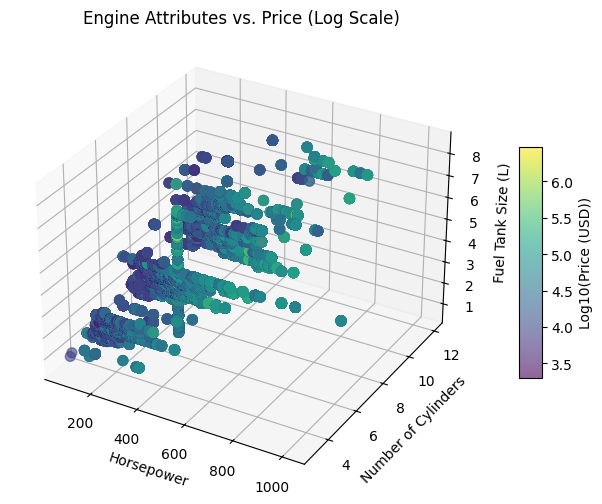

In [130]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

prices_log = np.log10(df_preprocessed['price'])

# Scatter plot
sc = ax.scatter(df_preprocessed['horse_power'], df_preprocessed['num_cylinders'],
				df_preprocessed['tank_size'], c=prices_log,
				cmap='viridis', s=50, alpha=0.6)

# Add labels and title
ax.set_title('Engine Attributes vs. Price (Log Scale)')
ax.set_xlabel('Horsepower')
ax.set_ylabel('Number of Cylinders')
ax.set_zlabel('Fuel Tank Size (L)')

# Add a color bar to represent the price
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Log10(Price (USD))')

plt.show()


### 3.2 Correlation heatmap between all the numerical attributes

We can see that model year and milage are strongly correlated, which makes sense.

Tank size and number of cylinders are even more strongly correlated, and to a lesser degree horse power and number of cylinders.

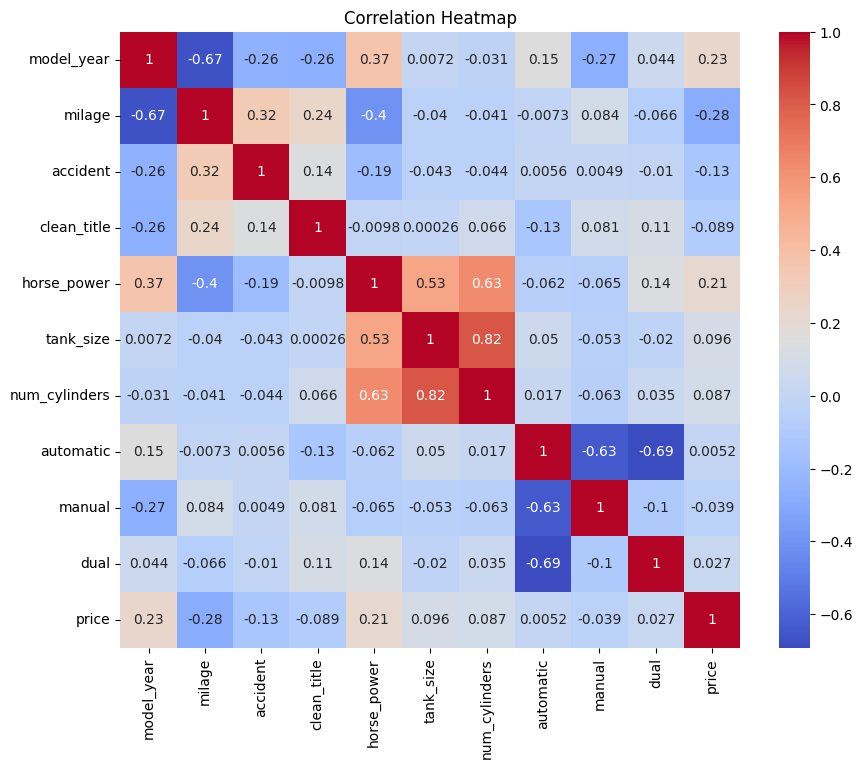

In [131]:
fig, ax = plt.subplots(figsize=(10,8))

numerical_cols = df_preprocessed.dtypes[(df_preprocessed.dtypes=="float64") | (df_preprocessed.dtypes=="int64") | (df_preprocessed.dtypes=="bool")].index.tolist()

corr_matrix = df_preprocessed[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation Heatmap')
plt.show()

### 3.3 Average Price by Fuel Type

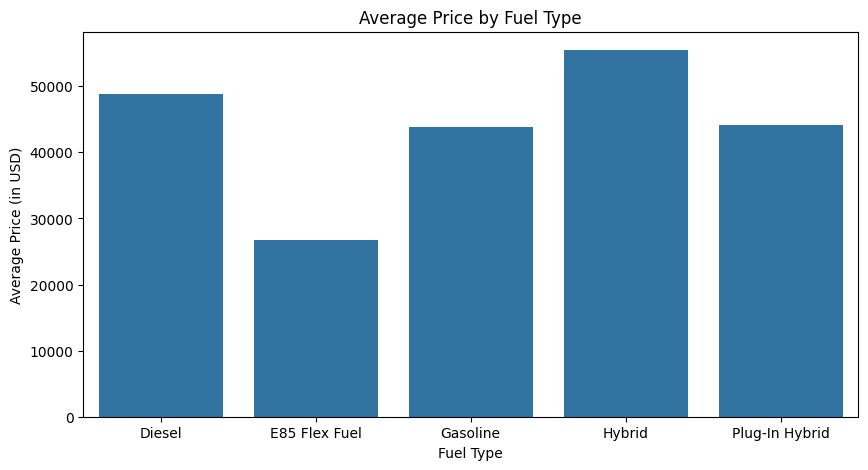

In [132]:
fig, ax = plt.subplots(figsize=(10,5))
avg_price_by_fuel = df_preprocessed.groupby('fuel_type')['price'].mean().reset_index()
sns.barplot(data=avg_price_by_fuel, x='fuel_type', y='price', ax=ax)
plt.title('Average Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average Price (in USD)')
plt.show()

### 3.4 Average Price by Brand and by the Accident History or Clean Title

We clearly see that a car that has not been in an accident costs a lot more than one that has, expectedly.

But suprisingly, cars which lack a "clear" title sell for more than those which have, albeit not by much on average.

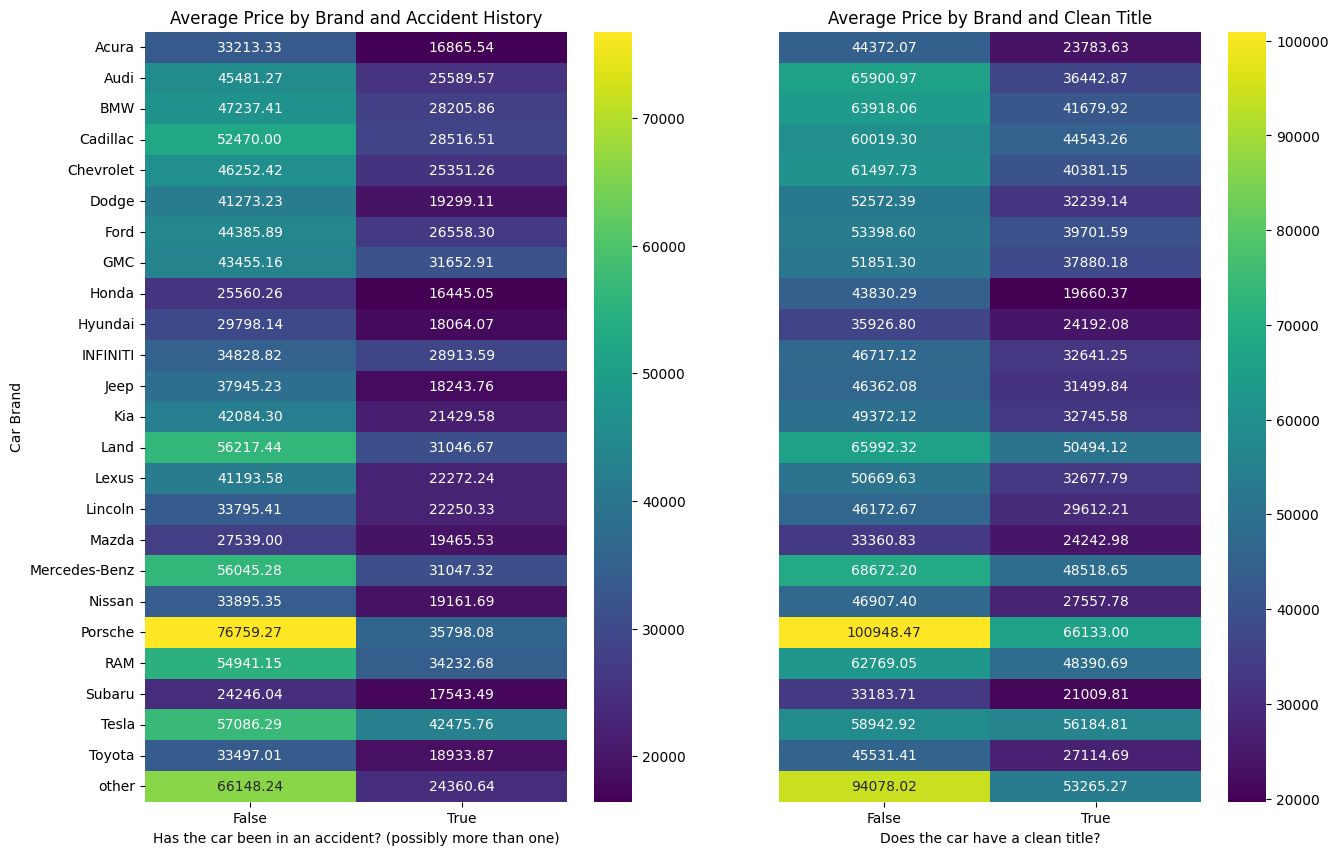

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

# The first is the y axis, the second is the x axis
avg_price_by_brand_accident = df_preprocessed.groupby(['brand', 'accident'])['price'].mean().unstack()
heatmap1 = sns.heatmap(avg_price_by_brand_accident, annot=True, fmt=".2f", cmap='viridis', ax=ax[0], cbar = True)
ax[0].set_title('Average Price by Brand and Accident History')
ax[0].set_xlabel('Has the car been in an accident? (possibly more than one)')
ax[0].set_ylabel('Car Brand')

# Remove when imputer is used
# df_clean = df_preprocessed.copy()
# df_clean['clean_title'] = df_clean['clean_title'].fillna(False)

avg_price_by_brand_clean = df_preprocessed.groupby(['brand', 'clean_title'])['price'].mean().unstack()
heatmap2 = sns.heatmap(avg_price_by_brand_clean, annot=True, fmt=".2f", cmap='viridis', ax=ax[1], cbar = True)
ax[1].set_title('Average Price by Brand and Clean Title')
ax[1].set_xlabel('Does the car have a clean title?')
ax[1].set_ylabel('')
ax[1].set_yticks([])

plt.show()

### 3.5 Distribution of Car Prices by Model Year Intervals using LOG

- The years are split into bins of 5 years (except for the first which is slighly bigger)
- Each bin is presented as a box plot.
- The price is shifted to a logarithmic scale.

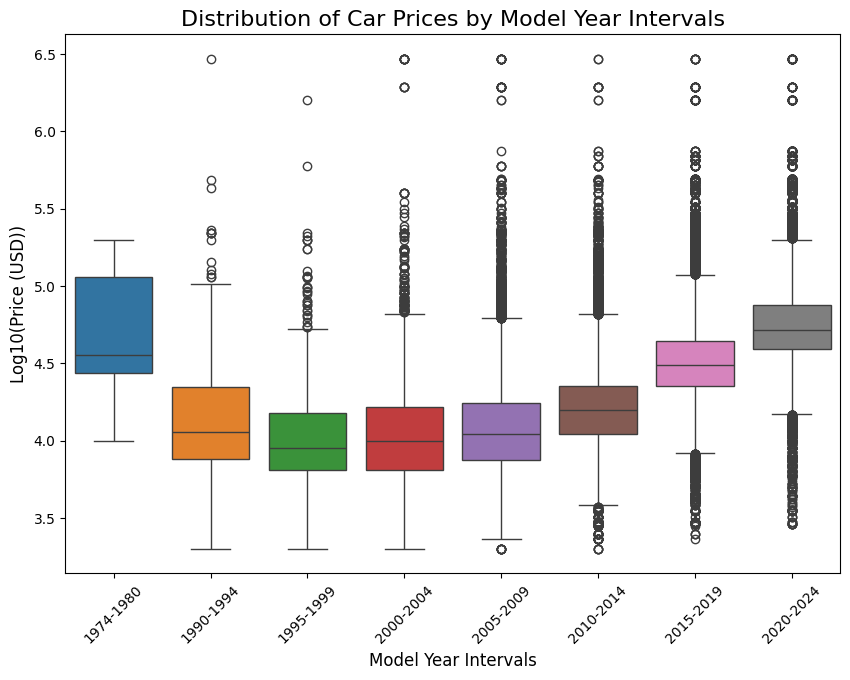

In [134]:
# Define the intervals
bins = [1973, 1980, 1994, 1999, 2004, 2009, 2014, 2019, 2024] 
labels = ["1974-1980", "1990-1994", "1995-1999", "2000-2004", "2005-2009", 
          "2010-2014", "2015-2019", "2020-2024"]

# Add an interval column
df_interval = df_preprocessed.copy()
df_interval['year_interval'] = pd.cut(df_interval['model_year'], bins=bins, labels=labels, right=True)

prices_log = np.log10(df_interval['price'])

# Create a box plot
plt.figure(figsize=(10, 7))
sns.boxplot(x='year_interval', y=prices_log, data=df_interval, hue='year_interval', legend=False)

# Add titles and labels
plt.title('Distribution of Car Prices by Model Year Intervals', fontsize=16)
plt.xlabel('Model Year Intervals', fontsize=12)
plt.ylabel('Log10(Price (USD))', fontsize=12)
plt.xticks(rotation=45)
plt.show()